In [2]:
import numpy
from matplotlib import pyplot
import py_monte_carlo
import scipy.sparse
import scipy.linalg

## Including Transverse field

In [32]:
edges =  [((0,1),-1.0), ((1,2), -1.0), ((2,3), -1.0), ((3,4), -1.0), ((4, 0), -1.0)]
transverse = 1.0
nvars = 5
betas = [0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 20.0, 40.0]

graphs = py_monte_carlo.LatticeTempering(edges)

for beta in betas:
    graphs.add_graph(transverse, beta)

In [33]:
results, energies = graphs.qmc_timesteps_sample(10000, 1)
q_transverse_data = numpy.mean(numpy.sum(results*2 - 1, axis=-1)**2, axis=-1)

In [34]:
def make_ham_and_spin(nvars, edges, transverse):
    ham = numpy.zeros((2**nvars,2**nvars))
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        h = 0.0
        for (vara, varb), j in edges:
            if state[vara] == state[varb]:
                h += j
            else:
                h -= j

        ham[i,i] += h
        for j in range(i+1, 2**nvars):
            b_state = [(j >> k) & 1 for k in range(nvars)]
            diffstate = [a^b for a,b in zip(state, b_state)]
            if sum(diffstate) != 1:
                continue
            for vark,s in enumerate(diffstate):
                if not s:
                    continue
                ham[i, j] = ham[i,j] + transverse
                ham[j, i] = ham[j,i] + transverse

    spin_diag = []
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        spin_diag.append(numpy.sum(numpy.asarray(state)*2 - 1)**2)
    spin_op = numpy.diag(spin_diag)
    return ham, spin_op

ham, spin_op = make_ham_and_spin(nvars, edges, transverse)

In [35]:
ed_transverse_data = []
ed_transverse_energies = []
for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    ed_transverse_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    ed_transverse_energies.append(numpy.trace(ham @ expm) / numpy.trace(expm))

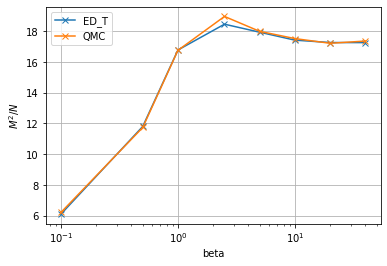

In [36]:
pyplot.plot(betas, ed_transverse_data, 'x-', label="ED_T")
pyplot.plot(betas, q_transverse_data, 'x-', label="QMC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()

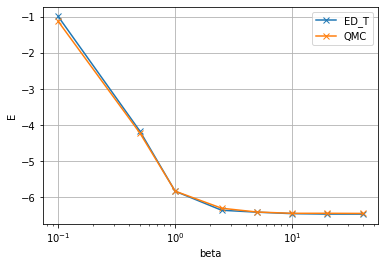

In [37]:
pyplot.plot(betas, ed_transverse_energies, 'x-', label="ED_T")
pyplot.plot(betas, energies, 'x-', label="QMC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("E")
pyplot.show()

## Autocorr

In [58]:
n = 256
edges = [((x, (x+1) % n), -1.0) for x in range(n)]
transverse = 0.2
betas = 2**numpy.linspace(-3,1,16)
graphs = py_monte_carlo.LatticeTempering(edges)

for beta in betas:
    graphs.add_graph(transverse, beta)
results = graphs.run_quantum_monte_carlo_and_measure_bond_autocorrelation(1000, sampling_wait_buffer=1000, replica_swap_freq=10000)

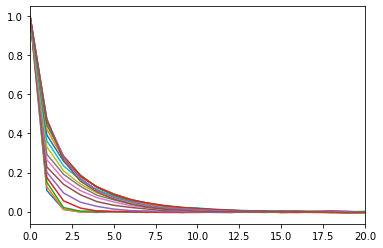

In [59]:
for i in range(results.shape[0]):
    pyplot.plot(results[i,:])
pyplot.xlim((0,20))
pyplot.show()

In [63]:
n = 256
edges = [((x, (x+1) % n), -1.0) for x in range(n)]
transverse = 0.2
betas = 2**numpy.linspace(-3,1,16)
graphs = py_monte_carlo.LatticeTempering(edges)

for beta in betas:
    graphs.add_graph(transverse, beta)
new_results = graphs.run_quantum_monte_carlo_and_measure_bond_autocorrelation(1000, sampling_wait_buffer=1000, replica_swap_freq=1)

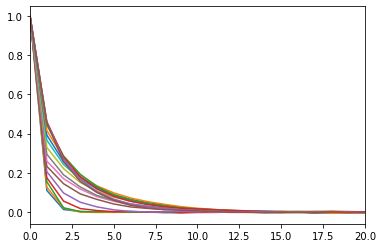

In [64]:
for i in range(results.shape[0]):
    pyplot.plot(new_results[i,:])
pyplot.xlim((0,20))
pyplot.show()